In [1]:
import pandas as pd

In [2]:
DATA_PATH = '/workspaces/fake-news-detector/Data/WELFake_Dataset.csv'

df = pd.read_csv(DATA_PATH)
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [3]:
# check missing values for columns
df.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [4]:
# clean dataframe from NaN values
df = df.dropna()

In [5]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

# Clean text

In [6]:

import nltk

In [7]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
stop_words = set(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
import string

def clean_word(word: str) -> str:

    word = word.lower()
    word = word.strip()

    for letter in word:
        if letter in string.punctuation:
            word = word.replace(letter, '')

    return word

In [9]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
def clean_text(text: str) -> list[str]:

    clean_text_list = []
    for word in text.split():
        cleaned_word = clean_word(word)
        if cleaned_word not in stop_words:
            clean_text_list.append(cleaned_word)

    return clean_text_list

In [11]:
text = "hola!, how are you today?"

clean_text(text)

['hola', 'today']

In [12]:
df["clean_text"] = df["text"].apply(clean_text)

In [13]:
df.head()

,Unnamed: 0,title,text,label,clean_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"[comment, expected, barack, obama, members, fy..."
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"[demonstrators, gathered, last, night, exercis..."
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"[dozen, politically, active, pastors, came, pr..."
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[rs28, sarmat, missile, dubbed, satan, 2, repl..."
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,"[say, one, time, someone, sued, southern, pove..."


# Vectorize words

In [14]:
import gensim

EMBEDDING_DIM = 100

sentences = df["clean_text"] # this is a list of list of words

model = gensim.models.Word2Vec(
    sentences=sentences,
    vector_size = EMBEDDING_DIM,
    window=5,
    min_count=1,
)

In [15]:
# check words close to spain

model.wv.most_similar("spain")

[('catalonia', 0.8538461327552795),
 ('madrid', 0.788003146648407),
 ('italy', 0.7689852714538574),
 ('catalan', 0.7216104865074158),
 ('greece', 0.7215298414230347),
 ('belgium', 0.7196012735366821),
 ('netherlands', 0.7052980661392212),
 ('puigdemont', 0.7031109929084778),
 ('poland', 0.6912689208984375),
 ('catalans', 0.6886179447174072)]

In [16]:
import numpy as np

def vectorize_text(text: list[str]) -> np.ndarray:
    
    text_vector = np.zeros(EMBEDDING_DIM)
    for word in text:
        word_vector = model.wv[word]
        text_vector += word_vector # equivalent to text_vector = text_vector + word_vector
    
    text_vector /= len(text)

    return text_vector

In [17]:
# add a column with the text converted to vectors

df["vector"] = df["clean_text"].apply(vectorize_text)

In [18]:
df.head()

,Unnamed: 0,title,text,label,clean_text,vector
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"[comment, expected, barack, obama, members, fy...","[-1.0339922674418254, 0.3541851037860334, -0.0..."
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"[demonstrators, gathered, last, night, exercis...","[-1.1288261324655087, 0.016113985152471633, 0...."
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"[dozen, politically, active, pastors, came, pr...","[-0.8592569719739626, 0.4759357086710607, -0.0..."
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[rs28, sarmat, missile, dubbed, satan, 2, repl...","[-0.5056832001422469, -0.008456706852105093, -..."
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,"[say, one, time, someone, sued, southern, pove...","[-0.5701073673553765, 0.08039959910994685, 0.3..."


# Train the model

In [19]:
import sklearn
import numpy as np

In [20]:
from sklearn.model_selection import train_test_split

X = np.stack(df["vector"].values)
y = df["label"]. values

# Assuming X train is your numpy array
nan_mask = np.isnan(X)
rows_with_nan = np.any(nan_mask, axis=1)
indices = np.where(rows_with_nan) [0]

X = np.delete(X, indices, axis=0)
y = np.delete(y, indices, axis=0)

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2)

In [21]:
from sklearn.svm import SVC

clf = SVC()

In [22]:
clf.fit(X_train, y_train)

SVC()

In [23]:
# evaluate

from sklearn.metrics import accuracy_score, precision_score, recall_score

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

accuracy, precision, recall

(0.9439932198601596, 0.9447706935123042, 0.9443745632424878)

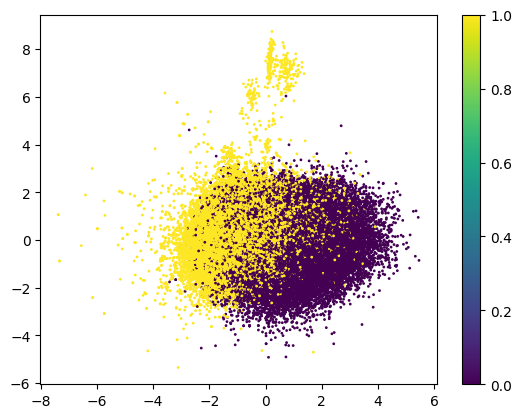

In [24]:
# plot X train vectors using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)

import matplotlib.pyplot as plt

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, s=1)
# plot legend
plt.colorbar()

plt.show()